In [1]:
import torch
from torch.utils.data import Dataset
from torch import nn
import numpy as np
from torch.utils.data import DataLoader
import lightning.pytorch as pl
from lightning.pytorch.callbacks import ModelCheckpoint
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
import h5py
import io
from PIL import Image
import matplotlib.pyplot as plt
import torchvision
from torchsummary import summary

In [2]:
class Text2ImageDataset(Dataset):
    def __init__(self,
                 datasetFile,
                 image_size,
                 transform=None,
                 datatype='train'):
      self.datasetFile = datasetFile
      self.transform = transform
      self.dataset = h5py.File(self.datasetFile, mode='r')
      self.datatype = datatype
      self.dataset_keys = [str(k) for k in self.dataset[datatype].keys()]
      self.resize_transform = A.Compose([
          A.Resize(height=image_size, width=image_size, interpolation=cv2.INTER_LANCZOS4, always_apply=True),
      ])

    def __len__(self):
        return len(self.dataset[self.datatype])

    def __getitem__(self, idx):
        example_name = self.dataset_keys[idx]
        example = self.dataset[self.datatype][example_name]

        right_image = bytes(np.array(example['img']))
        right_image = np.array(Image.open(io.BytesIO(right_image)))
        right_txt = str(np.array(example['txt']))
        right_embed = np.array(example['embeddings'], dtype=float)
        right_embed = torch.tensor(right_embed, dtype=torch.float32)

        wrong_example = self.getWrongImageTextEmbedding(example['class'])
        wrong_image = bytes(np.array(wrong_example['img']))
        wrong_image = np.array(Image.open(io.BytesIO(wrong_image)))
        wrong_embed = wrong_example['embeddings']
        wrong_embed = torch.tensor(wrong_embed, dtype=torch.float32)

        if(len(right_image.shape) < 3):
          right_image = cv2.cvtColor(right_image[:, :, None], cv2.COLOR_GRAY2RGB)

        if(len(wrong_image.shape) < 3):
          wrong_image = cv2.cvtColor(wrong_image[:, :, None], cv2.COLOR_GRAY2RGB)

        right_image = self.resize_transform(image=right_image)['image']
        wrong_image = self.resize_transform(image=wrong_image)['image']

        if(self.transform):
          right_image = self.transform(image=right_image)['image']
          wrong_image = self.transform(image=wrong_image)['image']

        sample = {
                'right_images': right_image,
                'right_embeddings': right_embed,
                'wrong_images': wrong_image,
                'wrong_embeddings' : wrong_embed,
                'right_txt': right_txt
                 }

        return sample

    def getWrongImageTextEmbedding(self, category):
        idx = np.random.randint(len(self.dataset_keys))
        example_name = self.dataset_keys[idx]
        example = self.dataset[self.datatype][example_name]
        _category = example['class']

        if _category != category:
            return example

        return self.getWrongImageTextEmbedding(category)

In [3]:
# -------------------
# Step 2: Define train, validation, test data in DataModule
# -------------------

class DataModule(pl.LightningDataModule):
    def __init__(self,
                 h5pyfile,
                 image_size,
                 batch_size):
      super().__init__()
      self.h5pyfile = h5pyfile
      self.batch_size = batch_size
      self.image_size = image_size
      self.train_transform = A.Compose([
          #A.HorizontalFlip(p=0.75),
          #A.ShiftScaleRotate(shift_limit=0.05, scale_limit=(0, 0.15), rotate_limit=0, p=0.75),
          # A.CLAHE(p=0.5),
          # A.HueSaturationValue(hue_shift_limit=(0, 0), p=0.5),
          A.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
          ToTensorV2()
      ])
      self.val_transform = A.Compose([
          A.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
          ToTensorV2()
      ])
    
    def setup(self, stage=None):
      self.train_dataset = Text2ImageDataset(self.h5pyfile, self.image_size, self.train_transform, 'train')
      self.val_dataset = Text2ImageDataset(self.h5pyfile, self.image_size, self.val_transform, 'valid')
      self.test_dataset = Text2ImageDataset(self.h5pyfile, self.image_size, self.val_transform, 'test')

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=False, num_workers=0)
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=0)
    
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=0)

In [40]:
# --------------------------------
# Step 3: Build your network
# --------------------------------
class Conv2D(nn.Module):
    def __init__(self, 
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride,
                 padding,
                 activation=nn.ReLU,
                 batch_norm=nn.BatchNorm2d,
                 if_act=True,
                 if_batch_norm=True):
        super().__init__()
        layers = []
        conv2D = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        layers.append(conv2D)
        # if(if_batch_norm):
        #     layers.append(batch_norm(out_channels, affine=True))
        if(if_act):
            layers.append(activation)
        self.convolution2D = nn.Sequential(*layers)

    def forward(self, x):
        return self.convolution2D(x)

In [41]:
class ConvTranspose2D(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride,
                 padding,
                 activation,
                 if_act=True,
                 if_batch_norm=True):
        super().__init__()
        layers = []
        conv_tr_2d = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        batch_norm = nn.BatchNorm2d(out_channels)
        layers.append(conv_tr_2d)
        if(if_batch_norm):
            layers.append(batch_norm)
        if(if_act):
            layers.append(activation)
        self.conv_transpose2d = nn.Sequential(*layers)

    def forward(self, x):
        return self.conv_transpose2d(x)

In [42]:
class LinearProjection(nn.Module):
    def __init__(self,
                 in_embedding_dim,
                 projected_embedding_dim,
                 activation):
        super().__init__()
        projection = nn.Linear(in_features=in_embedding_dim, out_features=projected_embedding_dim)
        batch_norm = nn.BatchNorm1d(projected_embedding_dim)
        self.linear_proj = nn.Sequential(projection, batch_norm, activation)

    def forward(self, x):
        return self.linear_proj(x)

In [43]:
class Generator(nn.Module):
  def __init__(self,
               in_embedding_dim,
               projected_embedding_dim,
               noise_dim,
               channels_dim,
               out_channels):
    super(Generator, self).__init__()
    concat_dim = projected_embedding_dim + noise_dim
    self.linear_projection = LinearProjection(in_embedding_dim=in_embedding_dim, projected_embedding_dim=projected_embedding_dim, activation = nn.LeakyReLU(negative_slope=0.2, inplace=True))
    self.generator = nn.Sequential(ConvTranspose2D(in_channels=concat_dim, out_channels=channels_dim * 8, kernel_size=4, stride=1, padding=0, activation=nn.ReLU(inplace=True)), # Output: (channels_dim*8) x 4 x 4                               
                                   ConvTranspose2D(in_channels=channels_dim * 8, out_channels=channels_dim * 4, kernel_size=4, stride=2, padding=1, activation=nn.ReLU(inplace=True)), # Output: (channels_dim*4) x 8 x 8                                
                                   ConvTranspose2D(in_channels=channels_dim * 4, out_channels=channels_dim * 2, kernel_size=4, stride=2, padding=1, activation=nn.ReLU(inplace=True)), # Output: (channels_dim*2) x 16 x 16                                  
                                   ConvTranspose2D(in_channels=channels_dim * 2, out_channels=channels_dim, kernel_size=4, stride=2, padding=1, activation=nn.ReLU(inplace=True)), # Output: (channels_dim) x 32 x 32                                  
                                   ConvTranspose2D(in_channels=channels_dim, out_channels=out_channels, kernel_size=4, stride=2, padding=1, activation=nn.Tanh(), if_batch_norm=False) # Output: (out_channels) x 64 x 64
                                  )
  
  def forward(self, input_embedding, noise):
    x = self.linear_projection(input_embedding).unsqueeze(2).unsqueeze(3)
    x = torch.cat([x, noise], 1)
    x = self.generator(x)
    return x

class Critic(nn.Module):
  def __init__(self,
               in_channels,
               channels_dim,
               out_embedding_dim,
               out_projected_embedding_dim):
    super(Critic, self).__init__()
    self.critic = nn.Sequential(Conv2D(in_channels=in_channels, out_channels=channels_dim, kernel_size=4, stride=2, padding=1, activation=nn.LeakyReLU(negative_slope=0.2, inplace=True), if_batch_norm=False),
                                       Conv2D(in_channels=channels_dim, out_channels=channels_dim * 2, kernel_size=4, stride=2, padding=1, activation=nn.LeakyReLU(negative_slope=0.2, inplace=True), batch_norm=nn.InstanceNorm2d),
                                       Conv2D(in_channels=channels_dim * 2, out_channels=channels_dim * 4, kernel_size=4, stride=2, padding=1, activation=nn.LeakyReLU(negative_slope=0.2, inplace=True), batch_norm=nn.InstanceNorm2d),
                                       Conv2D(in_channels=channels_dim * 4, out_channels=channels_dim * 8, kernel_size=4, stride=2, padding=1, activation=nn.LeakyReLU(negative_slope=0.2, inplace=True), batch_norm=nn.InstanceNorm2d)
                                      )
    self.linear_projection = LinearProjection(in_embedding_dim=out_embedding_dim, projected_embedding_dim=out_projected_embedding_dim, activation = nn.LeakyReLU(negative_slope=0.2, inplace=True))
    self.last_conv2d_1 = Conv2D(in_channels=(channels_dim * 8) + out_projected_embedding_dim, out_channels=channels_dim * 8, kernel_size=1, stride=1, padding=0, activation=nn.LeakyReLU(negative_slope=0.2, inplace=True), batch_norm=nn.InstanceNorm2d)
    self.last_conv2d_2 = Conv2D(in_channels=channels_dim * 8, out_channels=1, kernel_size=4, stride=1, padding=0, if_act=False, if_batch_norm=False)
  
  def forward(self, input_image, input_embedding):
    x_d = self.critic(input_image)
    projected_embedding = self.linear_projection(input_embedding)
    replicated_embedding = projected_embedding.repeat(4, 4, 1, 1).permute(2, 3, 0, 1)
    x = torch.cat([x_d, replicated_embedding], 1)
    x = self.last_conv2d_1(x)
    x = self.last_conv2d_2(x)
    return torch.flatten(x)

In [80]:
# --------------------------------
# Step 4: Compile your model
# --------------------------------
class ModelCompilation(pl.LightningModule):
    def __init__(self,
                 model,
                 z_dim,
                 optimizer,
                 learning_rate,
                 n_critic=5):
        super().__init__()
        self.generator = model['generator']
        self.critic = model['critic']
        self.g_learning_rate = learning_rate['generator']
        self.d_learning_rate = learning_rate['critic']
        self.z_dim = z_dim
        self.optimizer = optimizer
        self.automatic_optimization = False

        self.initialize_weights(self.generator)
        self.initialize_weights(self.critic)

        self.n_critic = n_critic

    def forward(self, x):
      pass
    
    def configure_optimizers(self):
        self.gen_optimizer = self.optimizer(self.generator.parameters(), lr=self.g_learning_rate, betas=(0.0, 0.99))
        self.critic_optimizer = self.optimizer(self.critic.parameters(), lr=self.d_learning_rate, betas=(0.0, 0.99))
        return [self.gen_optimizer, self.critic_optimizer], []

    def training_step(self, batch, batch_idx):
        loss = self.common_step(batch, batch_idx, 'train')

    def common_step(self, batch, batch_idx, stage):
      right_images = batch['right_images'].to(device)
      right_embeddings = batch['right_embeddings'].to(device)
      wrong_images = batch['wrong_images'].to(device)
      wrong_embeddings = batch['wrong_embeddings'].to(device)

      noise = torch.randn(right_images.size(0), self.z_dim, 1, 1).to(device)
      fake_images = self.generator(right_embeddings, noise)

      ################## Train Critic########################
      r_outputs = self.critic(right_images, right_embeddings)
      f_outputs = self.critic(fake_images, right_embeddings)
      real_loss = -torch.mean(r_outputs)
      fake_loss = torch.mean(f_outputs)

      # Compute the gradient penalty
      alpha = torch.rand(right_images.size(0), 1, 1, 1).to(device)
      interpolated_images = (alpha * right_images + (1 - alpha) * fake_images).requires_grad_(True).to(device)
      interpolated_outputs = self.critic(interpolated_images, right_embeddings)
      gradients = torch.autograd.grad(outputs=interpolated_outputs, inputs=interpolated_images,
                                      grad_outputs=torch.ones(interpolated_outputs.size()).to(device),
                                      create_graph=True, retain_graph=True, only_inputs=True)[0]
      gradient_penalty = 10 * ((gradients.norm(2, dim=1) - 1) ** 2).mean()

      c_loss = real_loss + fake_loss + gradient_penalty
      self.critic_optimizer.zero_grad()
      self.manual_backward(c_loss, retain_graph=True)
      self.critic_optimizer.step()
      self.log(stage + '_critic_' + 'loss', c_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
      ################## Train Generator########################
      if(batch_idx % self.n_critic == 0):
          noise = torch.randn(right_images.size(0), self.z_dim, 1, 1).to(device)
          fake_images = self.generator(right_embeddings, noise)
          outputs= self.critic(fake_images, right_embeddings)
          g_loss = -torch.mean(outputs)
          self.gen_optimizer.zero_grad()
          self.manual_backward(g_loss)
          self.gen_optimizer.step()
          self.log(stage + '_generator_' + 'loss', g_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
          self.fake = fake_images
          self.right = right_images
          return g_loss
      return c_loss

    def on_train_epoch_end(self):
        grid = torchvision.utils.make_grid(self.fake[:24, ...], nrow=4, normalize=True, scale_each=True)
        fig = plt.figure(figsize=(10, 10))
        plt.imshow(np.moveaxis(grid.detach().cpu().numpy(), 0, -1), aspect='auto')
        plt.axis('off')
        plt.savefig('sample_' + str(self.current_epoch) + '.png')

    def initialize_weights(self, model):
        # Initializes weights according to the DCGAN paper
        for m in model.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
                nn.init.normal_(m.weight.data, 0.0, 0.02)

In [81]:
# -------------------
# Step 5: Init your DataModule
# -------------------

batch_size = 64
image_size = 64
data_module = DataModule(h5pyfile='flowers(new embeddings).hdf5', image_size=image_size, batch_size=batch_size)

In [82]:
# -------------------
# Step 7: Init your model and its trainer with callbacks
# -------------------

device = 'cuda'

generator = Generator(in_embedding_dim=768,
                      projected_embedding_dim=128,
                      noise_dim=100,
                      channels_dim=64,
                      out_channels=3)

critic = Critic(in_channels=3,
                channels_dim=64,
                out_embedding_dim=768,
                out_projected_embedding_dim=128)

wgan = {'generator' : generator, 'critic' : critic}
optimizer = torch.optim.Adam
learning_rate = {'generator' : 1e-4, 'critic' : 1e-4}
n_critic = 5
zdim = 100

model = ModelCompilation(wgan, zdim, optimizer, learning_rate, n_critic)
trainer = pl.Trainer(precision='32', accelerator=device, devices="auto", max_epochs=100, enable_checkpointing=True)
# fast debug mode for your model
#trainer = pl.Trainer(precision='32', accelerator=device, devices="auto", fast_dev_run=5)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [83]:
# -------------------
# Step 8: Train your model
# -------------------
trainer.fit(model, datamodule=data_module)

You are using a CUDA device ('NVIDIA GeForce RTX 3060 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type      | Params
----------------------------------------
0 | generator | Generator | 738 K 
1 | critic    | Critic    | 306 K 
----------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.181     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [18]:
torch.save(model.state_dict(), 'model_weights.pth')

In [44]:
def testing(data_module, index, generator):
    data_module.setup()
    test_dataset = data_module.test_dataset
    sample = test_dataset.__getitem__(index)
    text = sample['right_txt']
    right_image = sample['right_images']
    right_image = (right_image.permute(1, 2, 0) + 1)/2
    right_embedding = sample['right_embeddings']
    noise = torch.randn(1, 100, 1, 1)
    generator.eval()
    generator.to('cpu')
    fake_image = generator(right_embedding[None, :].to('cpu'), noise.to('cpu'))[0]
    fake_image = fake_image.permute(1, 2, 0).detach().numpy()
    fake_image = (fake_image + 1)/2

    print(text)
    fig = plt.figure(figsize=(10, 7))
    rows = 1
    columns = 2
    fig.add_subplot(rows, columns, 1)
    plt.imshow(fake_image)
    plt.axis('off')
    plt.title("Generated")
    fig.add_subplot(rows, columns, 2)
    plt.imshow(right_image)
    plt.axis('off')
    plt.title("Real")

b'this flower has petals that are yellow and has green stamen\n'


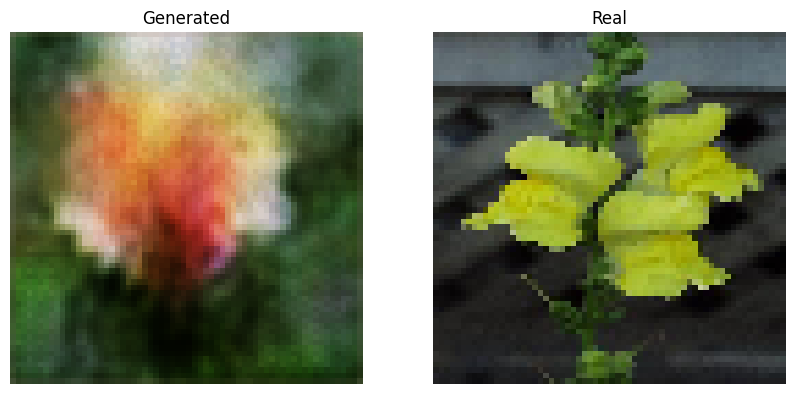

In [53]:
testing(data_module, 5, generator)